**Install all necessary libraries**

In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install Pillow

In [ ]:
16 left - lowyfl1.bmp
1 right - aevar1.bmp
1 left - aeval1.bmp

## **Load the image:** 
**Use OpenCV to load the image.**

In [8]:
import cv2
img = cv2.imread("MMU-Iris-Database/1/left/aeval1.bmp", cv2.IMREAD_COLOR)
cv2.imshow("image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
#check for the size/dimensions of the image
img.shape

(240, 320, 3)

## **Preprocess the image:** 
**Apply some image processing techniques such as smoothing, thresholding, and morphological operations to enhance the image.**

In [10]:
# Convert the image to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Calculate the mean and standard deviation of the grayscale image
mean, std_dev = cv2.meanStdDev(img_gray)

# Check if the image has noise
if std_dev > 10:
    # Apply a median filter to the grayscale image
    img_filtered = cv2.medianBlur(img_gray, 5)
else:
    # Apply a Gaussian filter to the grayscale image
    img_filtered = cv2.GaussianBlur(img_gray, (5, 5), 0)

# Apply adaptive thresholding to the blurred image
img_thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Apply canny edge detection to detect edges
edges = cv2.Canny(img_gray, threshold1=30, threshold2=100)

# Display the filtered image
cv2.imshow('Original Image', img)
cv2.imshow('Filtered Image', img_filtered)
cv2.imshow('Thresholding', img_thresh)
cv2.imshow('canny edge',edges)
cv2.waitKey(0)
cv2.destroyAllWindows()

## **Applying Erosion**

Text(0.5, 1.0, 'Erosion Image')

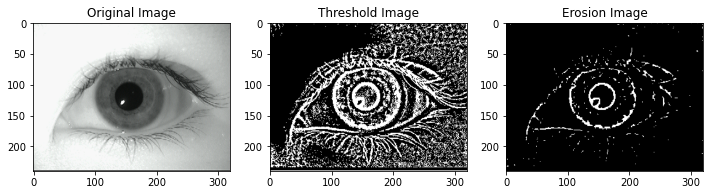

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(img_thresh,kernel,iterations = 1)

#plt.subplot(121),plt.imshow(erosion),plt.title('Erosion Image')

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img, cmap='gray') 
ax[0].set_title('Original Image')
ax[1].imshow(img_thresh, cmap='gray') 
ax[1].set_title('Threshold Image')
ax[2].imshow(erosion, cmap='gray') 
ax[2].set_title('Erosion Image')

## **Extracting the ROI**

**Detect the iris region: Apply Circular Hough Transform to detect the iris region. You can use the HoughCircles function in OpenCV to apply Circular Hough Transform.**

In [12]:
#outer_b = img.copy()
circles = cv2.HoughCircles(erosion, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)

# Convert the (x, y) coordinates and radius of the circles to integers
circles = np.round(circles[0, :]).astype("int")

# Draw circles on the original image
for (x, y, r) in circles:
    cv2.circle(img, (x, y), r, (0, 255, 0), 2)

# Display the image
cv2.imshow("Detected Circles", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
#inner_b = img.copy()
detected_circles = cv2.HoughCircles(erosion,cv2.HOUGH_GRADIENT, 1, 20, param1 = 50,param2 = 30, minRadius = 1, maxRadius = 40)

# Draw circles that are detected.
if detected_circles is not None:
    detected_circles = np.uint16(np.around(detected_circles))

    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]

# Draw the circumference of the circle.
        cv2.circle(img, (a, b), r, (0, 255, 0), 2)

# Draw a small circle (of radius 1) to show the center.
        cv2.circle(img, (a, b), 1, (0, 0, 255), 3)
cv2.imshow("Detected Circle", img)
cv2.waitKey(0)

-1

There are three arguments in cv2.findContours() function, first one is source image, second is contour retrieval mode, third is contour approximation method. And it outputs a modified image, the contours and hierarchy. contours is a Python list of all the contours in the image. Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.

To draw the contours, cv.drawContours function is used.  Its first argument is source image, second argument is the contours which should be passed as a Python list, third argument is index of contours (useful when drawing individual contour. To draw all contours, pass -1) and remaining arguments are color, thickness etc.

In [15]:
ret, im = cv2.threshold(erosion, 100, 255, cv2.THRESH_BINARY_INV)
contours, hierarchy  = cv2.findContours(im, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
con = cv2.drawContours(img, contours, 0, (0,255,0), 2)
cv2.imshow('With contors',con)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Boundary extraction techniques

There are two types of boundaries in binary images.

***Inner boundary:*** It is the difference between the original image and the eroded image. The eroded image is the shrunk image when erosion is applied to the original image. On taking the difference between the original image and the eroded version, we get the inner boundary of the image. The inner boundary is the part of the main surface separating the other surface. Erosion shrinks the white portion thus the boundary is the part of the white surface itself.

           Inner boundary = Original image - Eroded image

***Outer boundary:*** It is the difference between dilated image and an original image. The dilated image is the expanded image when dilation is applied to the original image. Dilation increases the white portion of the image. On taking the difference between dilated and original versions of the image we get the boundary which is the lost art of the black surface of the original image.

            Outer boundary = Dilated image - Original image

## **Segment the iris region:** 
 **Crop the detected iris region and segmented iris region.**

In [ ]:
# Convert the image to grayscale
gray = cv2.cvtColor(con, cv2.COLOR_BGR2GRAY)

# Apply a threshold to convert the grayscale image to binary
ret, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

# Find the contours in the binary image
contours, hierarchy = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) >= 2:
    # Sort the contours by area in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Select the outer and inner contours
    outer_contour = contours[0]
    inner_contour = contours[1]

    # Create a mask with zeros
    mask = np.zeros_like(gray)

    # Draw the outer contour on the mask with a thickness of -1 to fill the region
    cv2.drawContours(mask, [outer_contour], 0, (255), thickness=cv2.FILLED)

    # Draw the inner contour on the mask with a thickness of -1 to subtract the region
    cv2.drawContours(mask, [inner_contour], 0, (0), thickness=cv2.FILLED)

    # Apply bitwise AND operation between the mask and the grayscale image
    result = cv2.bitwise_and(gray, gray, mask=mask)

    # Display the result
    cv2.imshow("image", img)
    cv2.imshow('Segmented_Iris', result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Iris not found")